In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from collections import Counter
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import balanced_accuracy_score, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost import plot_tree

from imblearn.combine import SMOTEENN


import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the cleaned dataset
data = pd.read_csv('Processed_Telecom_Churn.csv')

# Display the first few rows to inspect the data
data.head()

,telecom_partner,gender,age,state,city,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn,tenure_days,recent_customer,loyal_customer,age_group,is_senior_citizen,dependents_flag,salary_bracket,cost_efficiency
0,2,0,25,10,4,755597,4,124962,44.0,45.0,4987.0,0,1879,0,1,4,0,1,0,0.040620
1,2,0,55,16,5,125926,2,130556,62.0,39.0,5973.0,0,1879,0,1,1,0,1,0,0.046524
2,3,0,57,1,2,423976,0,148828,49.0,24.0,193.0,1,1879,0,1,1,0,0,3,0.001787
3,1,1,46,22,4,522841,1,38722,80.0,25.0,9377.0,1,1879,0,1,0,0,1,2,0.244867
4,1,0,26,24,2,740247,2,55098,78.0,15.0,1393.0,0,1879,0,1,4,0,1,0,0.026970


In [3]:
X = data.drop(columns=['churn'])
y = data['churn']
X.head()

,telecom_partner,gender,age,state,city,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,tenure_days,recent_customer,loyal_customer,age_group,is_senior_citizen,dependents_flag,salary_bracket,cost_efficiency
0,2,0,25,10,4,755597,4,124962,44.0,45.0,4987.0,1879,0,1,4,0,1,0,0.040620
1,2,0,55,16,5,125926,2,130556,62.0,39.0,5973.0,1879,0,1,1,0,1,0,0.046524
2,3,0,57,1,2,423976,0,148828,49.0,24.0,193.0,1879,0,1,1,0,0,3,0.001787
3,1,1,46,22,4,522841,1,38722,80.0,25.0,9377.0,1879,0,1,0,0,1,2,0.244867
4,1,0,26,24,2,740247,2,55098,78.0,15.0,1393.0,1879,0,1,4,0,1,0,0.026970


In [4]:
from sklearn.feature_selection import mutual_info_classif
# Calculate MI Scores
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create DataFrame for MI Scores
mi_data = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_data.sort_values(by='MI Score', ascending=False, inplace=True)

# Display feature importance
print("Mutual Information Scores:")
print(mi_data)

Mutual Information Scores:
              Feature  MI Score
16    dependents_flag  0.035680
1              gender  0.033095
14          age_group  0.010046
0     telecom_partner  0.009781
6      num_dependents  0.007103
4                city  0.006840
15  is_senior_citizen  0.006635
13     loyal_customer  0.006576
12    recent_customer  0.005854
17     salary_bracket  0.003448
9            sms_sent  0.001925
3               state  0.001376
2                 age  0.000556
11        tenure_days  0.000384
10          data_used  0.000137
8          calls_made  0.000063
7    estimated_salary  0.000000
5             pincode  0.000000
18    cost_efficiency  0.000000


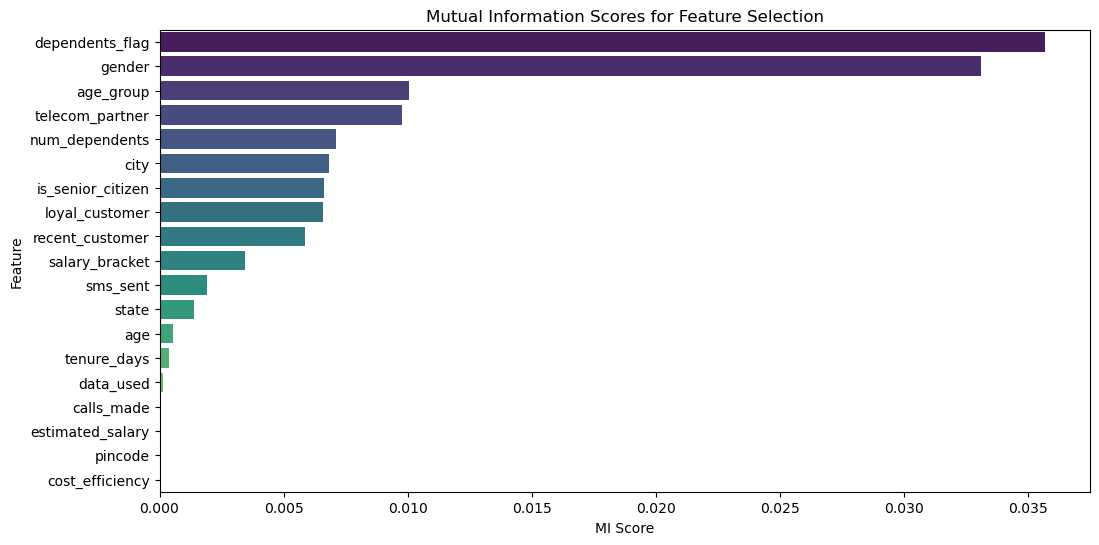

In [5]:
# Visualize MI Scores
plt.figure(figsize=(12, 6))
sns.barplot(x='MI Score', y='Feature', data=mi_data, palette='viridis')
plt.title('Mutual Information Scores for Feature Selection')
plt.show()

In [6]:
# Select Features with MI Score > 0
selected_features = mi_data[mi_data['MI Score'] > 0]['Feature'].tolist()
X = X[selected_features]

print("Selected Features:", selected_features)

Selected Features: ['dependents_flag', 'gender', 'age_group', 'telecom_partner', 'num_dependents', 'city', 'is_senior_citizen', 'loyal_customer', 'recent_customer', 'salary_bracket', 'sms_sent', 'state', 'age', 'tenure_days', 'data_used', 'calls_made']


In [7]:
# Class Distribution Before SMOTEENN
print("Class distribution before SMOTEENN:", Counter(y))

# Apply SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X, y)

# Class Distribution After SMOTEENN
print("Class distribution after SMOTEENN:", Counter(y_train_resampled))

Class distribution before SMOTEENN: Counter({0: 194726, 1: 48827})
Class distribution after SMOTEENN: Counter({1: 157555, 0: 77561})


In [8]:
# Perform stratified train-test split to maintain the class distribution
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)

In [9]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (188092, 16)
X_test shape: (47024, 16)


In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
#List to store models
models = []

In [12]:
# Function to print the evaluation metrics
def eval_metrics(model, X_test, y_test):
    y_pred_model = model.predict(X_test)       
    y_probabilities = model.predict_proba(X_test)[:, 1]
    
    
    #Try different threshold values 
    threshold = 0.4
    y_pred_model = (y_probabilities > threshold).astype(int)
    
    print('Precision: ', precision_score(y_test, y_pred_model))
    print('Recall: ', recall_score(y_test, y_pred_model))
    print('F1 Score: ', f1_score(y_test, y_pred_model))
    print('ROC AUC Score: ', roc_auc_score(y_test, y_probabilities))
   
    plt.figure(figsize=(12,6))
   
    
    
    # Confusion matrix
    plt.subplot(121)
    conf_mat = confusion_matrix(y_test, y_pred_model)
    sns.heatmap(conf_mat, fmt="d", annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('True Values')
    plt.xlabel('Predicted Values')

    # ROC AUC Score
    model_roc_auc = roc_auc_score(y_test, y_probabilities) 
    fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)
    
    plt.subplot(122)
    plt.plot(fpr, tpr, color='darkorange', lw=1, label="AUC : %.3f" % model_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    plt.show()
    
   

Precision:  0.694679924849929
Recall:  0.9621731403909621
F1 Score:  0.8068336038745043
ROC AUC Score:  0.7089758249712186


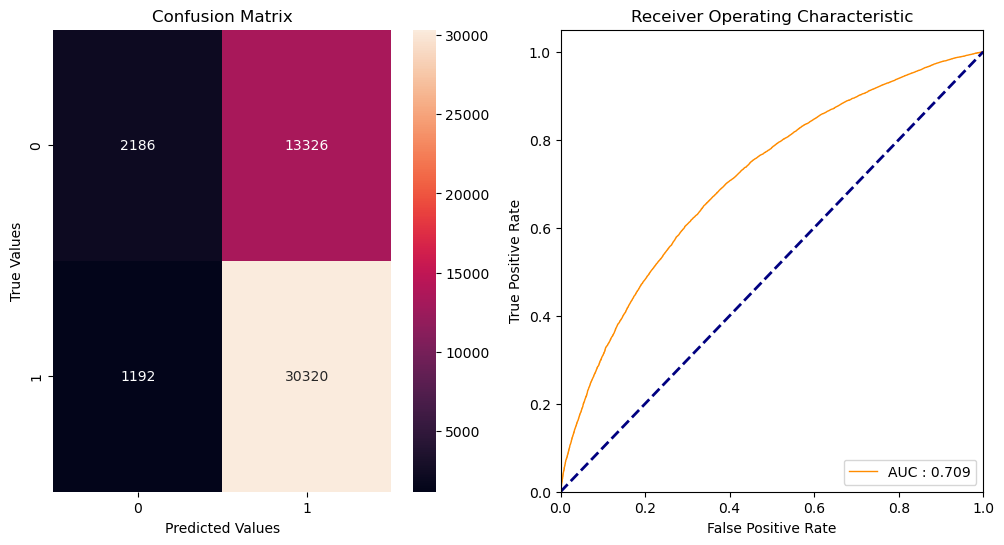

In [13]:
# Initialize and fit different models
# 1. Logistic Regression
churn_lr = LogisticRegression(random_state=42, max_iter=1000)
churn_lr.fit(X_train, y_train)
models.append(churn_lr)
eval_metrics(churn_lr, X_test, y_test)

Precision:  0.8052426275550008
Recall:  0.8188626554963189
F1 Score:  0.8119955315700867
ROC AUC Score:  0.7082644891715735


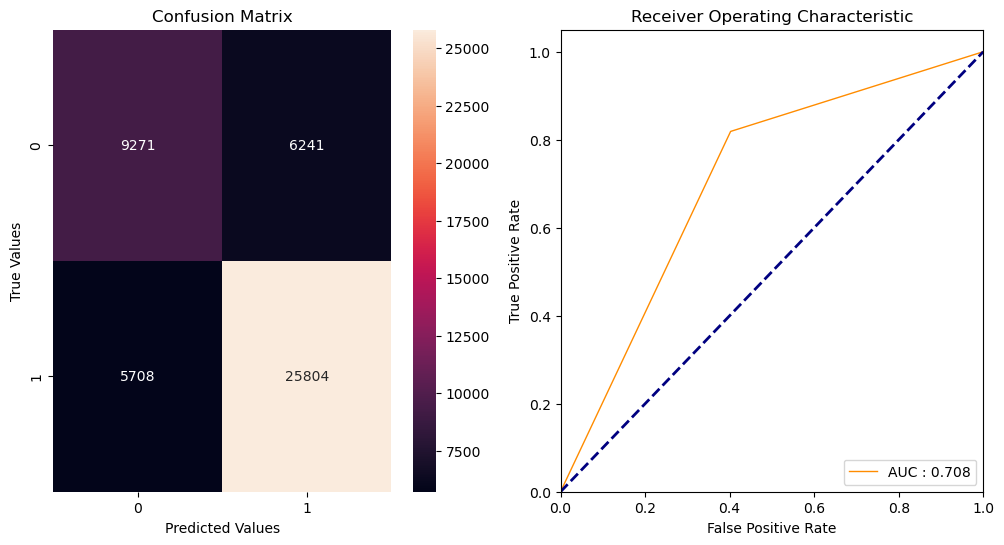

In [14]:
# 2. DecisionTreeClassifier
churn_DT = DecisionTreeClassifier(random_state=42)
churn_DT.fit(X_train, y_train)
models.append(churn_DT)
eval_metrics(churn_DT, X_test, y_test)

Precision:  0.7400597867781276
Recall:  0.8877570449352628
F1 Score:  0.8072078830810958
ROC AUC Score:  0.7448845874639831


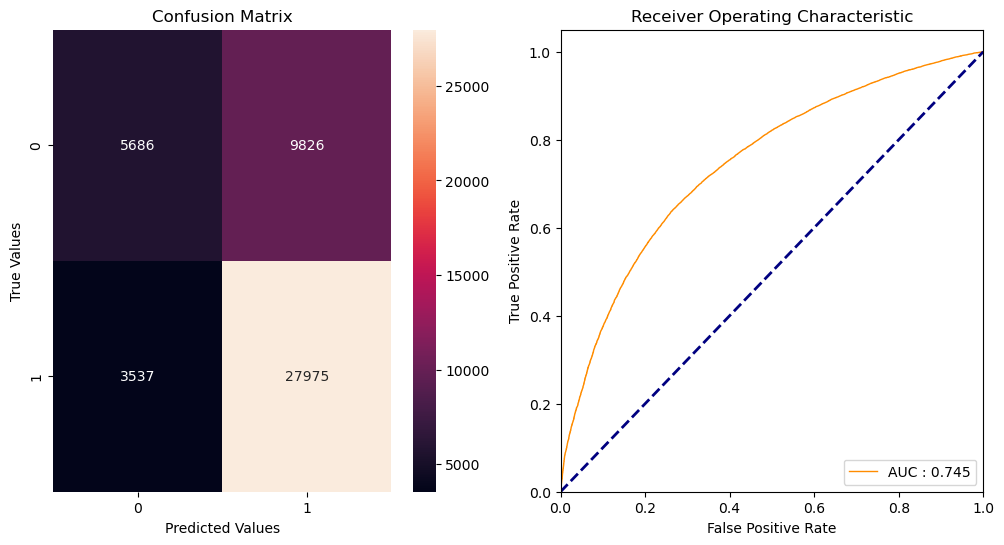

In [15]:
# 3. Gaussian Naive Bayes
churn_GNB = GaussianNB()
churn_GNB.fit(X_train, y_train)
models.append(churn_GNB)
eval_metrics(churn_GNB, X_test, y_test)

Precision:  0.7734452786523506
Recall:  0.9120969789286621
F1 Score:  0.8370684257277241
ROC AUC Score:  0.8756531858865361


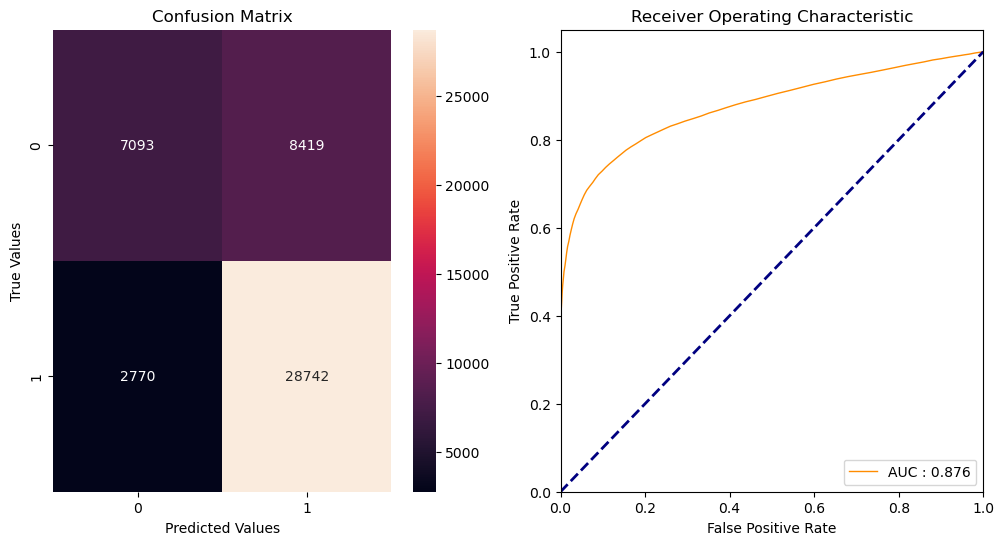

In [16]:
# 4. Random Forest
churn_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
churn_rf.fit(X_train, y_train)
models.append(churn_rf)
eval_metrics(churn_rf, X_test, y_test)

Precision:  0.7329864982038895
Recall:  0.9389121604468139
F1 Score:  0.8232675264688287
ROC AUC Score:  0.852582768145105


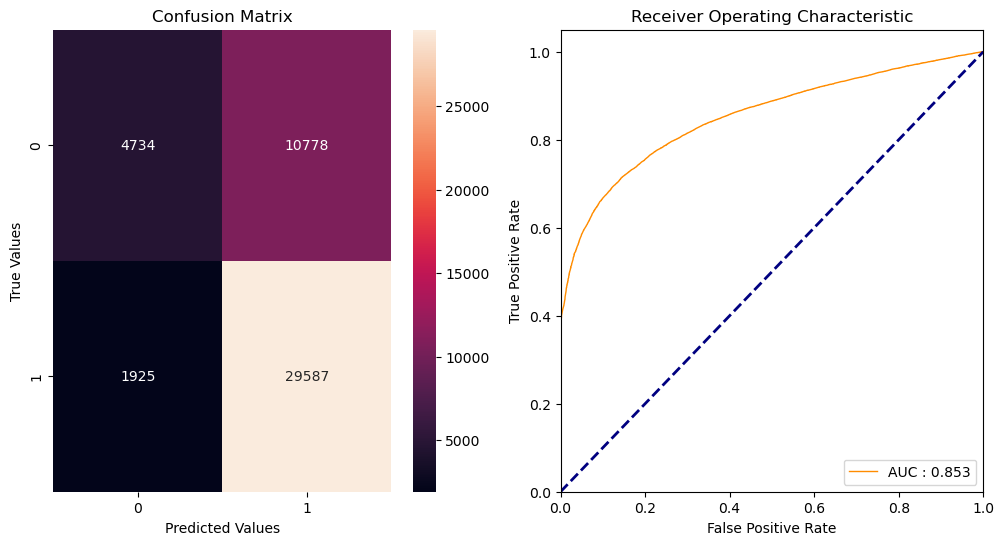

In [17]:
# 5. Gradient Boosting
churn_gb = GradientBoostingClassifier(random_state=42)
churn_gb.fit(X_train, y_train)
models.append(churn_gb)
eval_metrics(churn_gb, X_test, y_test)

Precision:  0.817418895676413
Recall:  0.8747461284589998
F1 Score:  0.8451114449520188
ROC AUC Score:  0.8900634736952292


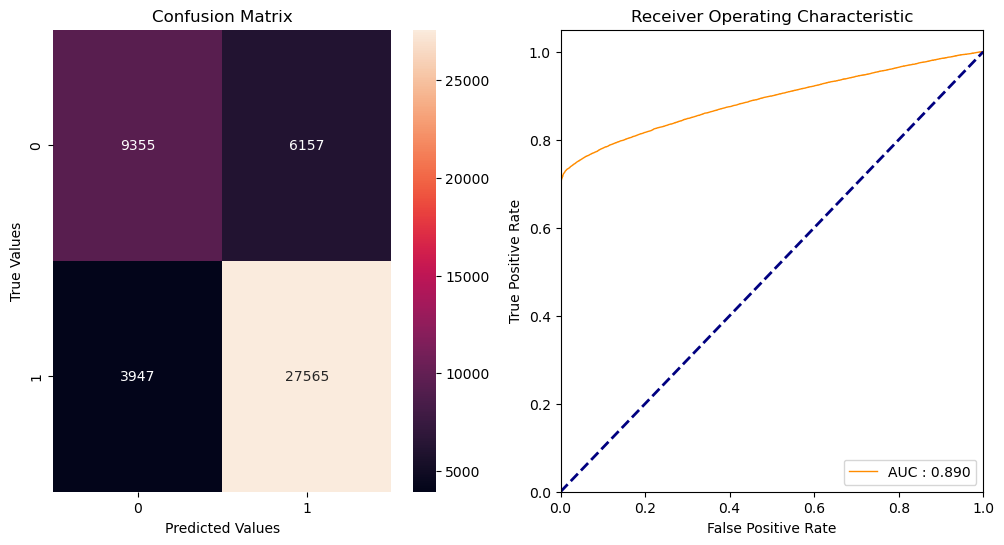

In [18]:
#6. XGBoost
churn_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, eval_metric="aucpr", use_label_encoder=False, n_jobs=-1)
churn_xgb.fit(X_train, y_train)
models.append(churn_xgb)
eval_metrics(churn_xgb, X_test, y_test)

In [19]:
from sklearn.model_selection import StratifiedKFold
# Model Comparison using K-Fold Cross Validation
result_col = ["Algorithm", "AUC Mean", "Bal Acc Mean", "Recall", "F1"]
model_results = pd.DataFrame(columns=result_col)

i = 0
for model in models:
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    cv_acc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="balanced_accuracy", n_jobs=-1)
    cv_auc_results = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring="roc_auc", n_jobs=-1)
    cv_recall_results = cross_val_score(model, X_train, y_train,
                                        cv=skf, scoring="recall", n_jobs=-1)
    cv_f1_results = cross_val_score(model, X_train, y_train,
                                        cv=skf, scoring="f1", n_jobs=-1)
   

    model_results.loc[i] = [model.__class__.__name__,
                                    round(cv_auc_results.mean() * 100, 2),
                                    round(cv_acc_results.mean() * 100, 2),
                                    round(cv_recall_results.mean() * 100, 2),
                                    round(cv_f1_results.mean() * 100, 2)
                                    
                           ]
    i += 1

model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)
print(model_results)

                    Algorithm  AUC Mean  Bal Acc Mean  Recall     F1
5               XGBClassifier     88.93         80.80   81.69  85.28
3      RandomForestClassifier     86.38         75.05   84.42  83.87
4  GradientBoostingClassifier     84.97         69.56   88.40  83.14
2                  GaussianNB     74.12         65.20   83.52  79.67
0          LogisticRegression     70.60         59.73   89.93  80.07
1      DecisionTreeClassifier     68.89         68.89   80.58  79.92


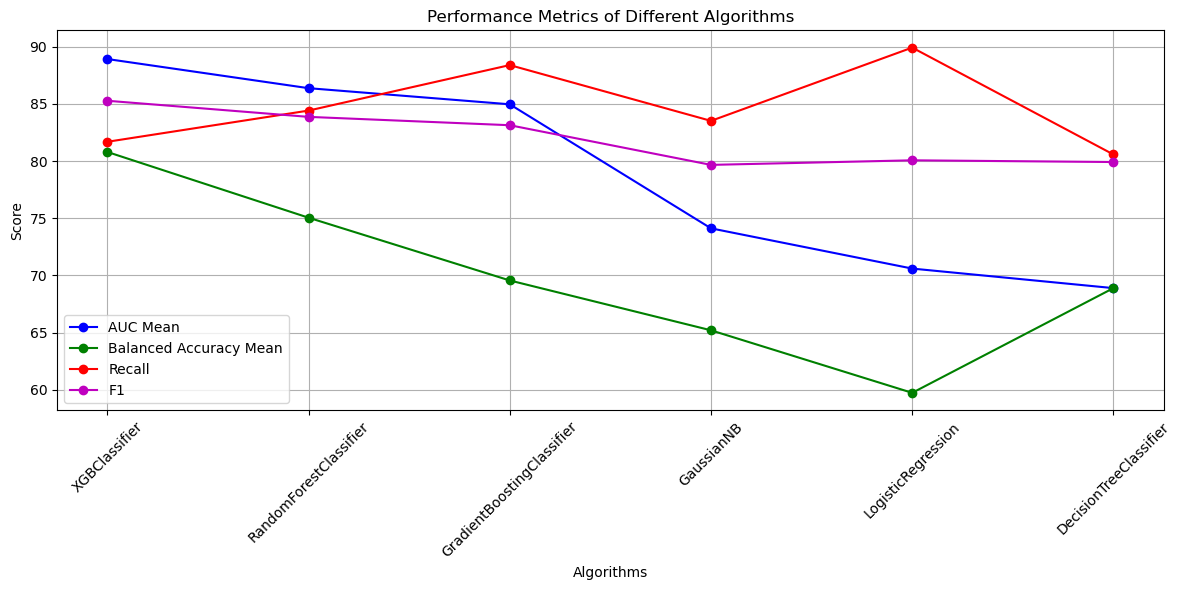

In [20]:
# Sort results by AUC score
model_results = model_results.sort_values(by=['AUC Mean'], ascending=False)

# Plot model performance
plt.figure(figsize=(12, 6))
plt.plot(model_results['Algorithm'], model_results['AUC Mean'], marker='o', label='AUC Mean', color='b')
plt.plot(model_results['Algorithm'], model_results['Bal Acc Mean'], marker='o', label='Balanced Accuracy Mean', color='g')
plt.plot(model_results['Algorithm'], model_results['Recall'], marker='o', label='Recall', color='r')
plt.plot(model_results['Algorithm'], model_results['F1'], marker='o', label='F1', color='m')


plt.xticks(rotation=45)
plt.xlabel('Algorithms')
plt.ylabel('Score')
plt.title('Performance Metrics of Different Algorithms')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define hyperparameter search space
rf_params_dist = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [10, 20, 30, None],  
    'max_features': ['sqrt', 'log2', None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf' : [1, 2, 4],
    'class_weight': ['balanced'],  
    'ccp_alpha': [0.0, 0.01, 0.1]
}

# Initialize base model
churn_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Perform Randomized Search with Cross-Validation
rf_random = RandomizedSearchCV(
    churn_rf, 
    rf_params_dist, 
    scoring='roc_auc', 
    cv=skf, 
    n_iter=20,  # Randomly search 20 combinations
    verbose=2,  
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
rf_random.fit(X_train, y_train)

# Get best parameters
best_params = rf_random.best_params_
print("Best Parameters for RF:", best_params)
print("Best Score for RF:", rf_random.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters for RF: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': None, 'class_weight': 'balanced', 'ccp_alpha': 0.0}
Best Score for RF: 0.864564653756501


In [22]:
# Train the optimized model
churn_rf_optimal = RandomForestClassifier(
                                           n_estimators=best_params['n_estimators'],
                                           max_depth=best_params['max_depth'],
                                           max_features=best_params['max_features'],
                                           min_samples_split=best_params['min_samples_split'],
                                           min_samples_leaf=best_params['min_samples_leaf'],
                                           class_weight=best_params['class_weight'],
                                           ccp_alpha=best_params['ccp_alpha'],
                                           random_state=42,
                                           n_jobs=-1
                                          )

# Fit the model on training data
churn_rf_optimal.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features=None,
                       min_samples_leaf=2, n_estimators=200, n_jobs=-1,
                       random_state=42)

Random Forest Model Evaluation:
Precision:  0.7887918974875496
Recall:  0.8946750444275197
F1 Score:  0.8384036637226039
ROC AUC Score:  0.8781201848774653


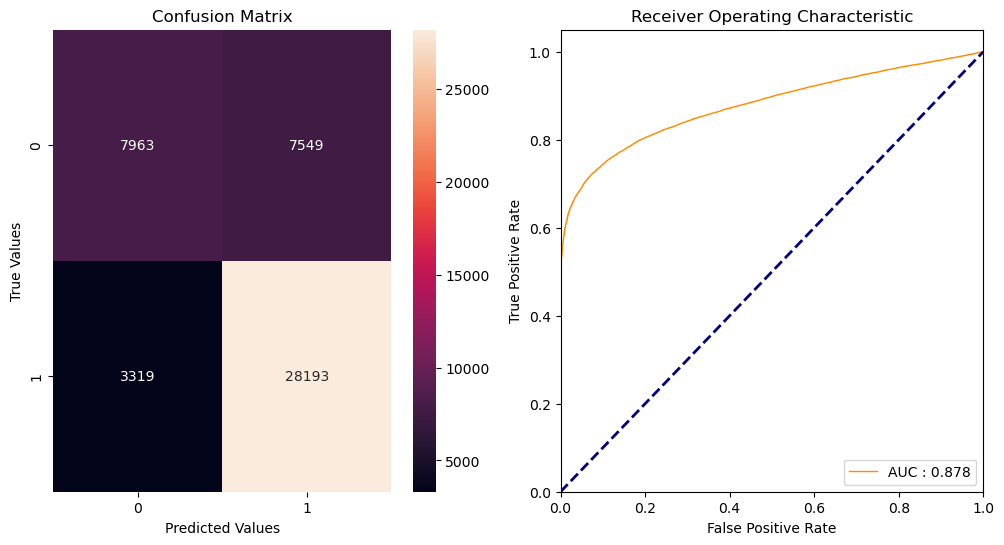

In [23]:
# Evaluate performance
print("Random Forest Model Evaluation:")
eval_metrics(churn_rf_optimal, X_test, y_test)

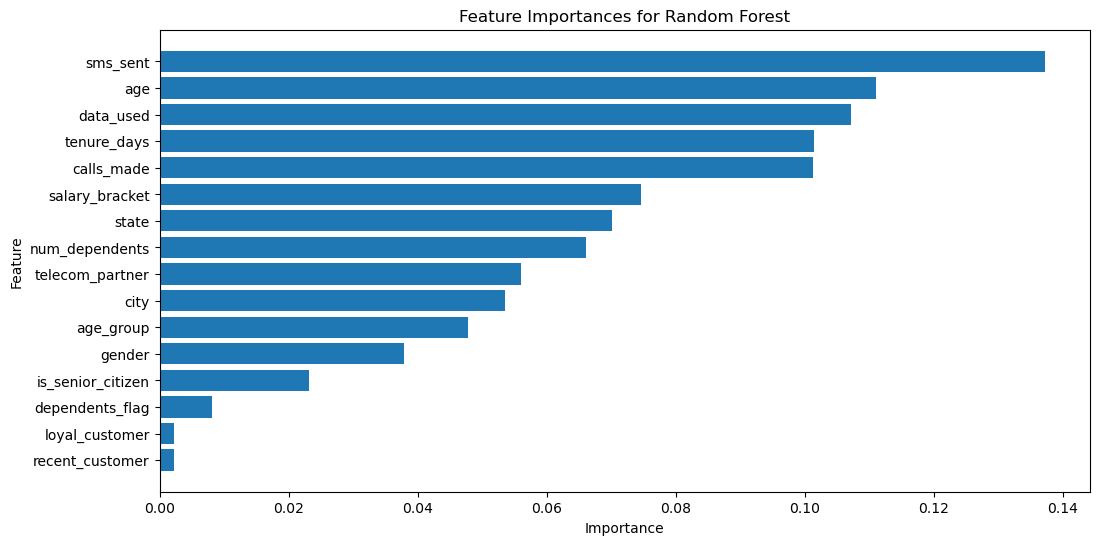

In [24]:
# Feature importance visualization for Random Forest
importances = churn_rf_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Random Forest')
plt.show()

In [37]:
# Define hyperparameter search space

xgb_params_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2], 
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3], 
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10],  
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'scale_pos_weight': [0.5, 1, 1.5, 2, 5], 
    'max_delta_step': [0, 1, 3, 5], 
    'tree_method': ['hist']
}

# Initialize base model
churn_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42, n_jobs=-1, eval_metric="aucpr", use_label_encoder=False)


# Perform Randomized Search
xgb_random = RandomizedSearchCV(
    churn_xgb,
    xgb_params_dist,
    scoring='roc_auc',
    cv=skf,
    n_iter=20,  # Randomly search 20 combinations
    verbose=2,
    n_jobs=-1
)

# Fit RandomizedSearchCV
xgb_random.fit(X_train, y_train)

# Get best parameters
best_params = xgb_random.best_params_
print("Best Parameters for XGBoost:", best_params)
print("Best Score for XGBoost:", xgb_random.best_score_)




Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters for XGBoost: {'tree_method': 'hist', 'subsample': 1.0, 'scale_pos_weight': 1.5, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 10, 'max_delta_step': 1, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}
Best Score for XGBoost: 0.9034230353612887


In [38]:
# Train the optimized model
churn_xgb_optimal = xgb.XGBClassifier(objective='binary:logistic',
                                  n_estimators=best_params['n_estimators'],
                                  learning_rate=best_params['learning_rate'],
                                  max_depth=best_params['max_depth'],
                                  min_child_weight=best_params['min_child_weight'],
                                  gamma=best_params['gamma'],
                                  reg_alpha=best_params['reg_alpha'],
                                  reg_lambda=best_params['reg_lambda'],
                                  subsample=best_params['subsample'],
                                  colsample_bytree=best_params['colsample_bytree'],
                                  scale_pos_weight=best_params['scale_pos_weight'],
                                  max_delta_step=best_params['max_delta_step'],
                                  tree_method=best_params['tree_method'],
                                  seed=42,
                                  n_jobs=-1,
                                  use_label_encoder=False,
                                  eval_metric="aucpr",
                                  early_stopping_rounds=10,
                                 )

# Fit the model on training data
churn_xgb_optimal.fit(X_train, y_train,
                     eval_set=[(X_test, y_test)],
                     verbose=True
                     )

[0]	validation_0-aucpr:0.87787
[1]	validation_0-aucpr:0.89568
[2]	validation_0-aucpr:0.90299
[3]	validation_0-aucpr:0.90500
[4]	validation_0-aucpr:0.90839
[5]	validation_0-aucpr:0.91498
[6]	validation_0-aucpr:0.91669
[7]	validation_0-aucpr:0.91926
[8]	validation_0-aucpr:0.92035
[9]	validation_0-aucpr:0.92234
[10]	validation_0-aucpr:0.92395
[11]	validation_0-aucpr:0.92534
[12]	validation_0-aucpr:0.92625
[13]	validation_0-aucpr:0.92691
[14]	validation_0-aucpr:0.92794
[15]	validation_0-aucpr:0.92861
[16]	validation_0-aucpr:0.93019
[17]	validation_0-aucpr:0.93217
[18]	validation_0-aucpr:0.93285
[19]	validation_0-aucpr:0.93356
[20]	validation_0-aucpr:0.93467
[21]	validation_0-aucpr:0.93517
[22]	validation_0-aucpr:0.93553
[23]	validation_0-aucpr:0.93658
[24]	validation_0-aucpr:0.93806
[25]	validation_0-aucpr:0.93839
[26]	validation_0-aucpr:0.94009
[27]	validation_0-aucpr:0.94077
[28]	validation_0-aucpr:0.94142
[29]	validation_0-aucpr:0.94190
[30]	validation_0-aucpr:0.94258
[31]	validation_0-

[252]	validation_0-aucpr:0.96005
[253]	validation_0-aucpr:0.96008
[254]	validation_0-aucpr:0.96008
[255]	validation_0-aucpr:0.96013
[256]	validation_0-aucpr:0.96012
[257]	validation_0-aucpr:0.96012
[258]	validation_0-aucpr:0.96018
[259]	validation_0-aucpr:0.96023
[260]	validation_0-aucpr:0.96024
[261]	validation_0-aucpr:0.96027
[262]	validation_0-aucpr:0.96031
[263]	validation_0-aucpr:0.96032
[264]	validation_0-aucpr:0.96031
[265]	validation_0-aucpr:0.96033
[266]	validation_0-aucpr:0.96033
[267]	validation_0-aucpr:0.96034
[268]	validation_0-aucpr:0.96038
[269]	validation_0-aucpr:0.96040
[270]	validation_0-aucpr:0.96043
[271]	validation_0-aucpr:0.96043
[272]	validation_0-aucpr:0.96043
[273]	validation_0-aucpr:0.96046
[274]	validation_0-aucpr:0.96046
[275]	validation_0-aucpr:0.96045
[276]	validation_0-aucpr:0.96052
[277]	validation_0-aucpr:0.96053
[278]	validation_0-aucpr:0.96054
[279]	validation_0-aucpr:0.96061
[280]	validation_0-aucpr:0.96063
[281]	validation_0-aucpr:0.96065
[282]	vali

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=10, max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

XGBoost Model Evaluation:
Precision:  0.8250671807454142
Recall:  0.8963886773292714
F1 Score:  0.8592504714972318
ROC AUC Score:  0.9087145471387996


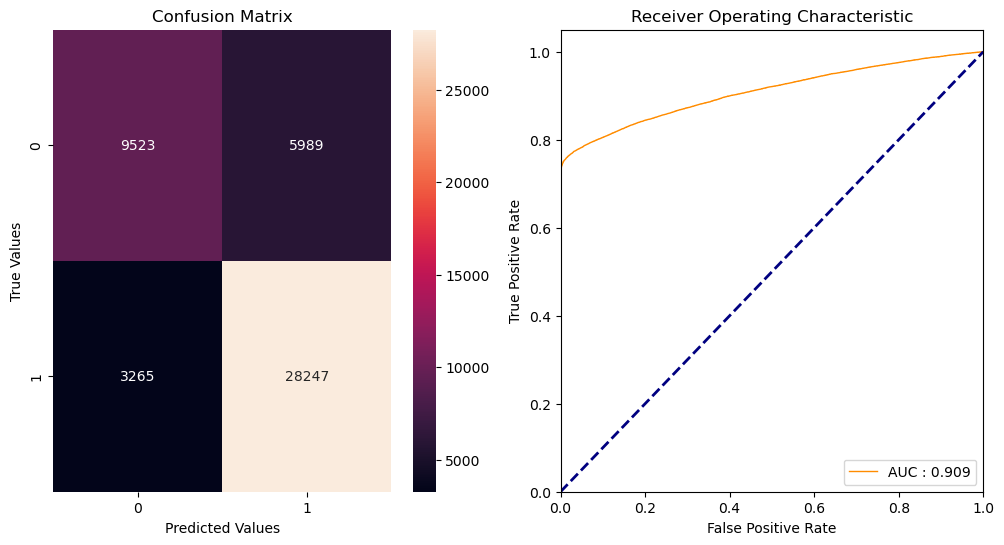

In [39]:
# Evaluate performance
print("XGBoost Model Evaluation:")
eval_metrics(churn_xgb_optimal, X_test, y_test)

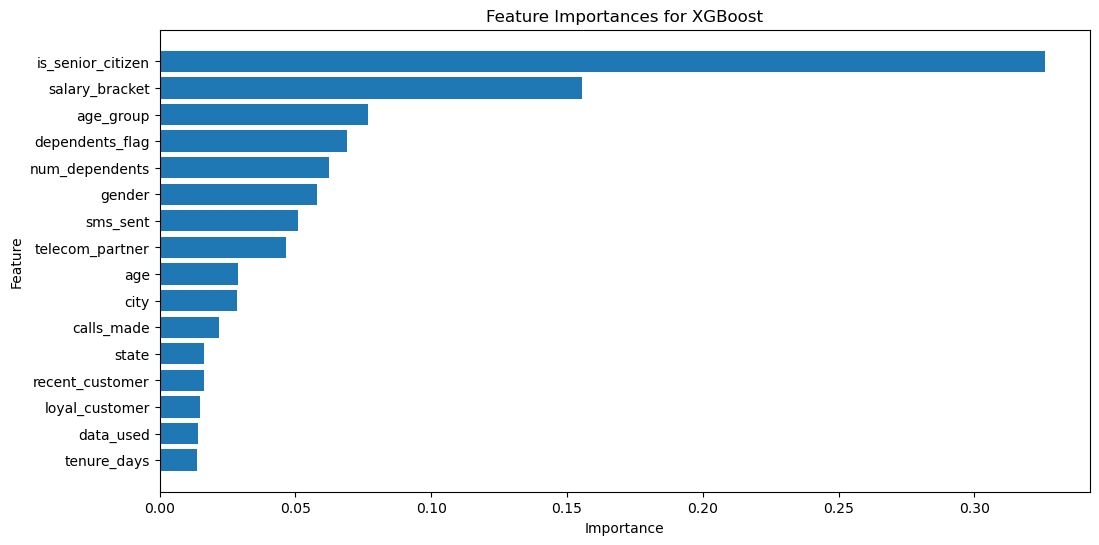

In [40]:
# Feature importance visualization for XGBoost
importances = churn_xgb_optimal.feature_importances_
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=True)

plt.figure(figsize=(12, 6))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for XGBoost')
plt.show()

In [41]:
import pickle

# Save the final XGBoost model to disk
pickle.dump(churn_xgb_optimal, open('churn_xgb_optimal.pkl', 'wb'))

In [42]:
# Save the final XGBoost model to disk
pickle.dump(churn_rf_optimal, open('churn_rf_optimal.pkl', 'wb'))